In [13]:

library(ggplot2)
library(reshape2)
library(dplyr)
library(egg)
library(grid)
library(tidyverse)
library(ggExtra)
#BiocManager::install("clusterProfiler")
library(clusterProfiler)
#BiocManager::install("org.Sc.sgd.db")
library(org.Sc.sgd.db)

In [14]:
data = read.csv("20230614_parsed_PPI_data.csv")

In [15]:
data = data %>% mutate(MaxPPI=pmax(PPI.Ortholog.GeneA,PPI.Ortholog.GeneB,PPI.Ortholog.Anc, na.rm = TRUE))
#data = data %>% rowwise() %>% mutate(SumPPI=sum(PPI.Ortholog.GeneA,PPI.Ortholog.GeneB,PPI.Ortholog.Anc, na.rm = TRUE))
data$AvePPI = rowMeans(data[,9:11], na.rm=TRUE)

#data = data %>% filter(AvePPI != "NaN")

data$RelPPI = data$AvePPI/data$PPI.Scer
data$RelPPIMax = data$MaxPPI/data$PPI.Scer
#unique(data$Ortholog.Species)
head(data)

,PPI_partner.Gene,PPI_partner.ORF,Ortholog.Species,State,PPI.NA,Ortholog.GeneA,Ortholog.GeneB,Ortholog.GeneAnc,PPI.Ortholog.GeneA,PPI.Ortholog.GeneB,PPI.Ortholog.Anc,PPI.A_div_B,PPI.Scer,PPI.Vehicle,MaxPPI,AvePPI,RelPPI,RelPPIMax
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,YLR027C,AAT2,T.delbrueckii,Anc,No,,,TDEL0E05230,NA,NA,51992.75,1.000000,10368.75,4043,51992.75,51992.75,5.014370,5.014370
2,YLR027C,AAT2,V.polyspora,AB,No,Kpol_1002.53,Kpol_1033.51,,29039.75,15932.00,NA,1.822731,10368.75,4043,29039.75,22485.88,2.168620,2.800699
3,YLR027C,AAT2,S.bayanusvar.uvarum,A,No,Suva_16.102,,,25431.25,NA,NA,25431.250000,10368.75,4043,25431.25,25431.25,2.452682,2.452682
4,YLR027C,AAT2,S.mikatae,A,No,Smik_6.409,,,10516.75,NA,NA,10516.750000,10368.75,4043,10516.75,10516.75,1.014274,1.014274
5,YLR027C,AAT2,S.kudriavzevii,A,No,Skud_16.75,,,10875.50,NA,NA,10875.500000,10368.75,4043,10875.50,10875.50,1.048873,1.048873
6,YLR027C,AAT2,K.africana,AB,No,KAFR0K00320,KAFR0C02290,,73575.50,31606.75,NA,2.327841,10368.75,4043,73575.50,52591.12,5.072080,7.095889


In [16]:
data_Ncas = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="N.castellii")
data_Ncas_ppi_A = data_Ncas %>% filter(PPI.Ortholog.GeneA > 10000)
data_Ncas_ppi_B = data_Ncas %>% filter(PPI.Ortholog.GeneB > 10000)

data_Kafr = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="K.africana")
data_Knag = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="K.naganishii")

data_Skud = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="S.kudriavzevii")
data_Tpha = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="T.phaffii")

data_Ndar = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="N.dairenensis")
data_Vpol = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="V.polyspora")

data_Tbla = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="T.blattae")

data_Scer = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species=="S.cerevisiae")
data_Scer_ppi = data_Scer %>% filter(MaxPPI > 10000)

In [17]:
species_list= c(
                    'T.delbrueckii',
                    'Z.rouxii' ,
                    'N.castellii',
                    'V.polyspora',
                    'K.africana' ,
                    'T.blattae'  ,
                    'N.dairenensis',
                    'K.naganishii',
                    'T.phaffii'   ,
                    'C.glabrata'  ,
                    'S.bayanusvar.uvarum' , 
                    'S.mikatae'           , 
                    'S.kudriavzevii'      ,
                    'S.cerevisiae'
)

In [18]:
species_dup_state = c(
                    'T.delbrueckii' = "Anc",
                    'Z.rouxii' = "Anc",
                    'N.castellii' = "AB",
                    'V.polyspora' = "AB",
                    'K.africana'  = "AB",
                    'T.blattae'   = "AB",
                    'N.dairenensis'="AB",
                    'K.naganishii'= "AB",
                    'T.phaffii'   = "AB",
                    'C.glabrata'          = "B",
                    'S.bayanusvar.uvarum' = "A", 
                    'S.mikatae'           = "A", 
                    'S.kudriavzevii'      = "A",
                    'S.cerevisiae'="A"
)

In [19]:
Scer = clusterProfiler::enrichGO(data_Scer_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
columns = c("ID","Description","geneID")

df_merged = data.frame(matrix(ncol = length(columns ), nrow = 0))
names(df_merged)= columns


In [20]:
for (species in unique(data$Ortholog.Species) ){
     data_sp = data %>% filter(PPI.NA=="No")%>% filter(Ortholog.Species==species)
    
   if (species %in% species_list) {
    species_dup = species_dup_state[[species]]
    
    if (species_dup == "Anc" ){
        sample = paste(species,species_dup,sep=".")
        
        data_ppi = data_sp %>% filter(PPI.Ortholog.Anc > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("./GO/",sample,".csv",sep=""))
    }#IF Anc
       
    if (species_dup == "AB" ){
        sample = paste(species,"A",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneA > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("./GO/",sample,".csv",sep=""))
        
        sample = paste(species,"B",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneB > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("./GO/",sample,".csv",sep=""))
    }#IF AB
       
    if (species_dup == "A" ){
        sample = paste(species,"A",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneA > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("./GO/",sample,".csv",sep=""))
    }#IF A
    if (species_dup == "B" ){
        sample = paste(species,"B",sep=".")
        data_ppi = data_sp %>% filter(PPI.Ortholog.GeneB > 10000)
        go_en    = clusterProfiler::enrichGO(data_ppi$PPI_partner.ORF, OrgDb = org.Sc.sgd.db::org.Sc.sgd.db, ont = "CC",  keyType = "GENENAME")
        df_go    = data.frame(go_en)
        #df_go$Ortholog = sample
        names(df_go)[6] = sample
        df_merged = merge(df_merged,df_go%>% dplyr::select(c(1,2,6,8)),by=c("ID","Description","geneID"), all=T)
        write.csv(df_go,paste("./GO/",sample,".csv",sep=""))
    }#IF B
       
    
   }#IF in species_list
    }# FOR species

In [21]:
write.csv(df_merged,paste("./GO/Merged_GO_adjPval_results.csv",sep=""))

In [22]:
df_merged[is.na(df_merged)] <- 1

In [23]:
df_agg = df_merged %>% group_by(Description) %>%
  summarize(T.delbrueckii.Anc       = min(T.delbrueckii.Anc),
            Z.rouxii.Anc            = min(Z.rouxii.Anc),
            S.cerevisiae.A          = min(S.cerevisiae.A),
            S.bayanusvar.uvarum.A   = min(S.bayanusvar.uvarum.A),
            S.mikatae.A             = min(S.mikatae.A),
            S.kudriavzevii.A        = min(S.kudriavzevii.A),
            C.glabrata.B            = min(C.glabrata.B),
            N.castellii.A           = min(N.castellii.A),
            N.castellii.B           = min(N.castellii.B),
            V.polyspora.A           = min(V.polyspora.A),
            V.polyspora.B           = min(V.polyspora.B),
            K.africana.A            = min(K.africana.A),
            K.africana.B            = min(K.africana.B),
            T.blattae.A             = min(T.blattae.A),
            T.blattae.B             = min(T.blattae.B),
            N.dairenensis.A         = min(N.dairenensis.A),
            N.dairenensis.B         = min(N.dairenensis.B),
            K.naganishii.A          = min(K.naganishii.A),
            K.naganishii.B          = min(K.naganishii.B),
            T.phaffii.A             = min(T.phaffii.A),
            T.phaffii.B             = min(T.phaffii.B)
           )

In [27]:
df_agg_hmap = melt(df_agg,id.vars=c("Description"))
df_agg_hmap$variable = factor(df_agg_hmap$variable,levels=c("T.delbrueckii.Anc","Z.rouxii.Anc","S.cerevisiae.A","S.bayanusvar.uvarum.A","S.mikatae.A","S.kudriavzevii.A","C.glabrata.B","N.castellii.A","N.castellii.B","V.polyspora.A","V.polyspora.B","K.africana.A","K.africana.B","T.blattae.A","T.blattae.B","N.dairenensis.A","N.dairenensis.B","K.naganishii.A","K.naganishii.B","T.phaffii.A","T.phaffii.B"))
#unique(df_agg_hmap$Description)
#df_agg_hmap$Description = factor(df_agg_hmap$Description,levels=c())
names(df_agg_hmap)[2] ="Ortholog"
names(df_agg_hmap)[3] ="Adjusted.Pval"

In [35]:
write.csv(df_agg_hmap,"GO_aggregated_results_l.csv")
write.csv(df_agg,"GO_aggregated_results.csv")


,Description,Ortholog,Adjusted.Pval
,<chr>,<fct>,<dbl>
1,COPI-coated vesicle,T.delbrueckii.Anc,1.000000000
2,COPI-coated vesicle membrane,T.delbrueckii.Anc,0.045603710
3,Golgi apparatus,T.delbrueckii.Anc,1.000000000
4,Golgi membrane,T.delbrueckii.Anc,0.009772048
5,Golgi-associated vesicle,T.delbrueckii.Anc,1.000000000
6,Golgi-associated vesicle membrane,T.delbrueckii.Anc,0.013765544


In [36]:
gos = c(
"actin cortical patch",
"actin cytoskeleton",
"cell tip",
"cellular bud",
"cellular bud neck",
"mating projection",
"mating projection tip",
"site of polarized growth",
"cortical actin cytoskeleton",
"cytoskeleton",
"cortical cytoskeleton",
"endocytic patch",
"plasma membrane bounded cell projection",
"cytoplasmic vesicle",
"cytoplasmic vesicle membrane",
"membrane microdomain",
"Golgi-associated vesicle membrane",
"vesicle",
"vesicle coat",
"vesicle membrane",
"vesicle tethering complex",
"COPI-coated vesicle membrane",
"clathrin-coated vesicle",
"transport vesicle membrane",
"vacuolar proton-transporting V-type ATPase complex",
"proton-transporting V-type ATPase complex",
"proton-transporting two-sector ATPase complex",
"coated membrane",
"coated vesicle",
"coated vesicle membrane",
"P-body",
"polysome",
"U6 snRNP")


In [43]:
df_agg_hmap2 = df_agg_hmap %>% filter(Description %in% gos)
#head(df_agg_hmap2)
df_agg_hmap2$Description = factor(df_agg_hmap2$Description,levels=gos)

In [44]:
head(df_agg_hmap2)

,Description,Ortholog,Adjusted.Pval
,<fct>,<fct>,<dbl>
1,COPI-coated vesicle membrane,T.delbrueckii.Anc,4.560371e-02
2,Golgi-associated vesicle membrane,T.delbrueckii.Anc,1.376554e-02
3,P-body,T.delbrueckii.Anc,3.293965e-02
4,U6 snRNP,T.delbrueckii.Anc,4.253112e-02
5,actin cortical patch,T.delbrueckii.Anc,1.491193e-12
6,actin cytoskeleton,T.delbrueckii.Anc,1.465297e-12


In [45]:
Y = length(unique(df_agg_hmap2$Description))
X = length(unique(df_agg_hmap2$Ortholog))


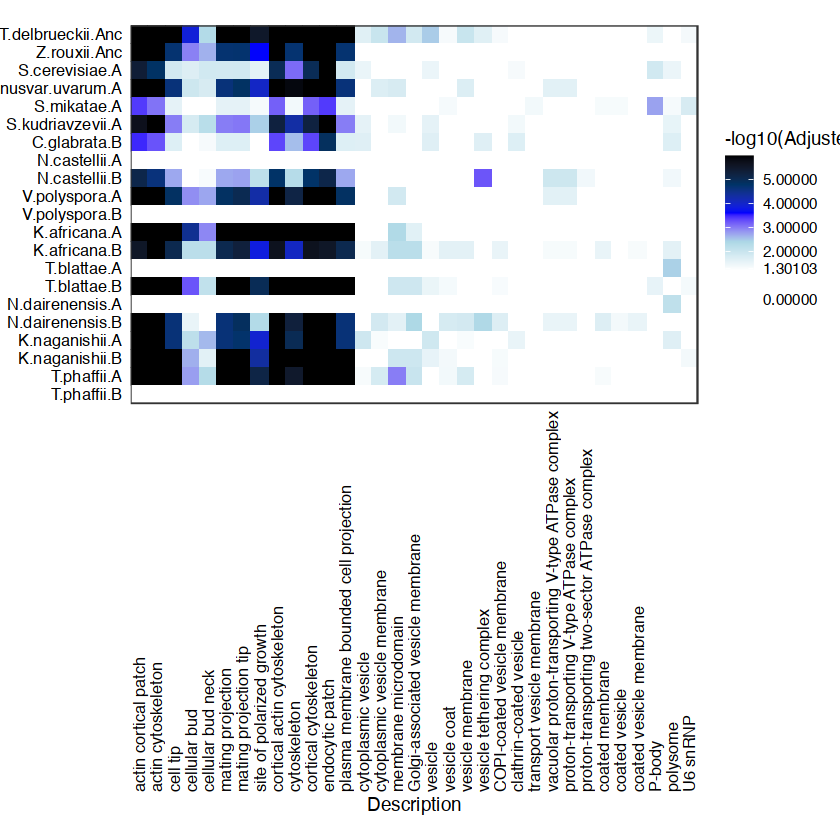

In [51]:
heatmap  =  ggplot(df_agg_hmap2 )+   
            geom_tile(aes(x=Description,y=Ortholog,fill = -log10(Adjusted.Pval)))  + 
            theme_bw()   + 
            theme(legend.position='right',
                  legend.key = element_blank(), 
                  strip.background = element_rect(colour="#FFFFFF", color="#FFFFFF",fill="#FFFFFF"),
                  panel.grid.minor = element_blank(),
                  panel.grid.major = element_blank(),
                  panel.background = element_blank(),
                  axis.ticks = element_blank(),
                  axis.text.x = element_text(size=9.5,color="#000000",angle=90,hjust=0,vjust=0.5),
                  axis.text.y = element_text(size=9.5,color="#000000")#element_blank()
                 )+ 
            scale_x_discrete(expand=c(0,0)) + 
            scale_y_discrete(expand=c(0,0),limits=rev) +
            scale_fill_gradientn(colors=c("#FFFFFF","#FFFFFF","#ADD8E6","#0000FF","#003366","#000000"),breaks=c(0,-log10(0.05),-log10(0.01),-log10(0.001),-log10(0.0001),-log10(0.00001)),limits=c(0,6),na.value="#000000")+
             scale_colour_continuous(guide = guide_legend(direction = "vertical", title.position = "left",
                             label.position="right", label.hjust = 0.5, label.vjust = 0.5,
                             label.theme = element_text(angle = 90)))

p <- set_panel_size(heatmap,width  = unit(12, "cm"),height = unit(8, "cm"))
grid.newpage()
grid.draw(p) 
ggsave(plot=p,"heatmap_GO_chosen.pdf",width  = unit(10, "cm"),height = unit(10, "cm"))